# Entendiendo AUC y ROC: Una Guía Didáctica

En este notebook vamos a desmitificar dos de los conceptos más importantes (y a veces confusos) en ciencia de datos: la **Curva ROC** y el **AUC**.

Lo haremos en dos partes:
1.  **El Ejemplo de la "Mini-Clase"**: Un ejemplo muy simple con solo 5 estudiantes para entender la lógica manual.
2.  **Tus Datos Reales**: Aplicaremos lo aprendido a tu modelo de predicción de deserción (Dropout).

---

## Parte 1: La Analogía del "Profesor Estricto"

Imagina que nuestro modelo es un profesor que intenta adivinar qué estudiantes van a abandonar (Clase Positiva = 1) y cuáles se quedarán (Clase Negativa = 0).

El modelo no dice "Sí" o "No" directamente. En su lugar, da una **probabilidad** (un puntaje de 0 a 1).

Para tomar una decisión final, necesitamos poner una regla, un **Umbral (Threshold)**.

-   **Umbral Bajo (0.1)**: El profesor es muy "alarmista". Si ve el más mínimo riesgo, dice que vas a abandonar. Atrapa a todos los que abandonan, pero acusa falsamente a muchos que no.
-   **Umbral Alto (0.9)**: El profesor es muy "relajado". Solo dice que vas a abandonar si está 100% seguro. No acusa a inocentes, pero se le escapan muchos estudiantes que sí abandonan.

La curva ROC es simplemente un dibujo de cómo cambia el comportamiento del profesor al mover este umbral.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

sns.set_theme(style="whitegrid")

# --- EJEMPLO DE JUGUETE ---
# Imaginemos 5 estudiantes. 
# 'Realidad': 1 = Abandonó, 0 = No abandonó
# 'Probabilidad_Modelo': Qué tan seguro estaba el modelo de que abandonarían.

data_juguete = pd.DataFrame({
    'Estudiante': ['Ana', 'Beto', 'Carla', 'Dani', 'Elena'],
    'Realidad':          [0,     0,      1,       1,      1],  # 2 No abandonan, 3 Sí abandonan
    'Probabilidad_Modelo': [0.1,   0.4,    0.35,    0.8,    0.9]   # El modelo se equivocó con Carla (le dio baja prob)
})

print("--- Datos de la Mini-Clase ---")
display(data_juguete)

--- Datos de la Mini-Clase ---


,Estudiante,Realidad,Probabilidad_Modelo
0,Ana,0,0.10
1,Beto,0,0.40
2,Carla,1,0.35
3,Dani,1,0.80
4,Elena,1,0.90


### Jugando con el Umbral

Vamos a ver qué pasa si ponemos el corte en **0.5** (lo estándar).

In [2]:
umbral = 0.5

# Si la probabilidad es mayor al umbral, predecimos 1 (Abandono)
data_juguete['Prediccion'] = (data_juguete['Probabilidad_Modelo'] >= umbral).astype(int)

display(data_juguete[['Estudiante', 'Realidad', 'Probabilidad_Modelo', 'Prediccion']])

# Calculamos los aciertos y errores
TP = ((data_juguete['Realidad'] == 1) & (data_juguete['Prediccion'] == 1)).sum() # Verdaderos Positivos (Dani, Elena)
FP = ((data_juguete['Realidad'] == 0) & (data_juguete['Prediccion'] == 1)).sum() # Falsos Positivos (Nadie)
TN = ((data_juguete['Realidad'] == 0) & (data_juguete['Prediccion'] == 0)).sum() # Verdaderos Negativos (Ana, Beto)
FN = ((data_juguete['Realidad'] == 1) & (data_juguete['Prediccion'] == 0)).sum() # Falsos Negativos (Carla - ¡Se nos escapó!)

print(f"Con umbral {umbral}:")
print(f"Atrapamos a {TP} de 3 abandonos (Sensibilidad/TPR = {TP/3:.2f})")
print(f"Acusamos falsamente a {FP} de 2 estudiantes (Falsos Positivos/FPR = {FP/2:.2f})")

,Estudiante,Realidad,Probabilidad_Modelo,Prediccion
0,Ana,0,0.10,0
1,Beto,0,0.40,0
2,Carla,1,0.35,0
3,Dani,1,0.80,1
4,Elena,1,0.90,1


Con umbral 0.5:
Atrapamos a 2 de 3 abandonos (Sensibilidad/TPR = 0.67)
Acusamos falsamente a 0 de 2 estudiantes (Falsos Positivos/FPR = 0.00)


### ¿Qué es la Curva ROC?

La curva ROC simplemente pone estos dos números en un gráfico para **TODOS** los umbrales posibles al mismo tiempo.

-   **Eje Y (TPR - Tasa de Verdaderos Positivos)**: ¿Qué porcentaje de los abandonos reales atrapamos? (Queremos que sea 1.0).
-   **Eje X (FPR - Tasa de Falsos Positivos)**: ¿Qué porcentaje de los estudiantes buenos acusamos por error? (Queremos que sea 0.0).

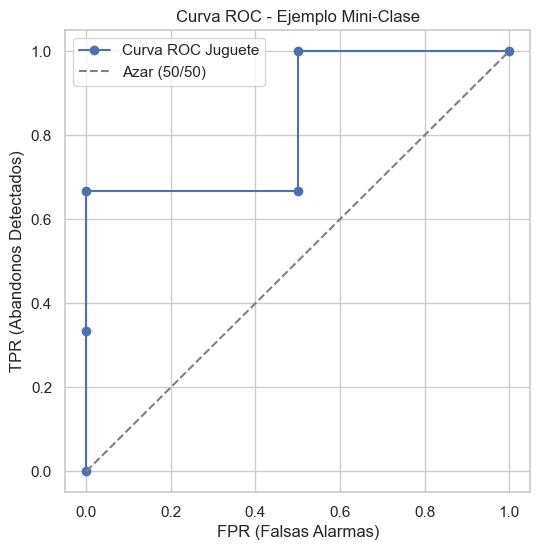

In [3]:
# Calculamos la curva ROC para el ejemplo de juguete
fpr_toy, tpr_toy, thresholds_toy = roc_curve(data_juguete['Realidad'], data_juguete['Probabilidad_Modelo'])

plt.figure(figsize=(6, 6))
plt.plot(fpr_toy, tpr_toy, marker='o', label='Curva ROC Juguete')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar (50/50)')
plt.xlabel('FPR (Falsas Alarmas)')
plt.ylabel('TPR (Abandonos Detectados)')
plt.title('Curva ROC - Ejemplo Mini-Clase')
plt.legend()
plt.show()

--- 
## Parte 2: Tus Datos Reales (Dropout Model)

Ahora veamos esto con tus miles de datos. Vamos a cargar el dataset procesado y entrenar un modelo rápido para ver su curva ROC.

In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# 1. Cargar datos
try:
    df = pd.read_parquet('../data/processed/preprocessed_data.parquet')
    print(f"Datos cargados: {df.shape}")
except:
    print("No se encontró el archivo en ../data/processed/. Verifica la ruta.")

# 2. Preparar X e y
X = df.drop('Target', axis=1)
y = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0) # 1 es Abandono

# Codificar variables categóricas (One-Hot Encoding)
X = pd.get_dummies(X)

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Entrenar Modelo (XGBoost simple)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 5. Obtener PROBABILIDADES (no solo predicciones 0/1)
y_probs = model.predict_proba(X_test)[:, 1] # Probabilidad de clase 1 (Dropout)

print("Modelo entrenado y probabilidades calculadas.")

Datos cargados: (4424, 51)
Modelo entrenado y probabilidades calculadas.


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:38:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Visualizando la Curva ROC Real y el AUC

**AUC (Area Under the Curve)** es el área sombreada bajo la línea azul.

-   **AUC = 0.5**: El modelo es basura (tira una moneda).
-   **AUC = 1.0**: El modelo es perfecto (Dios).
-   **AUC = 0.85**: El modelo es muy bueno.

**Interpretación Intuitiva del AUC:**
Si tienes un AUC de **0.85**, significa que si tomas un estudiante que SÍ abandonó y uno que NO abandonó al azar, hay un **85% de probabilidad** de que tu modelo le haya dado un puntaje de riesgo más alto al que sí abandonó.

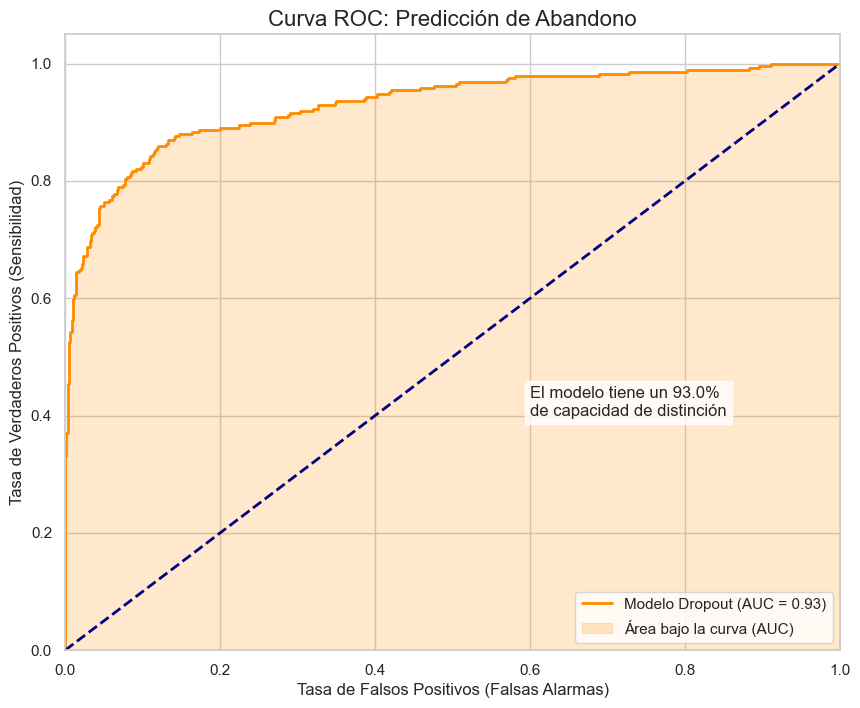

In [5]:
# Calcular ROC y AUC real
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))

# Dibujar la curva
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modelo Dropout (AUC = {roc_auc:.2f})')

# Línea de referencia (azar)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Rellenar el área bajo la curva
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange', label='Área bajo la curva (AUC)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (Falsas Alarmas)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
plt.title('Curva ROC: Predicción de Abandono', fontsize=16)
plt.legend(loc="lower right")

# Anotación didáctica
plt.text(0.6, 0.4, f'El modelo tiene un {roc_auc*100:.1f}%\nde capacidad de distinción', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

### Conclusión

1.  **La Curva** nos muestra el trade-off: si queremos atrapar a TODOS los desertores (ir hacia arriba en el eje Y), inevitablemente tendremos más falsas alarmas (ir a la derecha en el eje X).
2.  **El AUC** resume qué tan bueno es el modelo en general, sin importar qué umbral elijamos. Un valor alto (cercano a 1) nos da confianza de que el modelo está aprendiendo patrones reales y no solo adivinando.